# Wrangle

Import modules

In [1]:
import pandas as pd
import numpy as np
import os
from env import host, user, password
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import seaborn as sns
import matplotlib as plt

import warnings
warnings.filterwarnings("ignore")

## Acquire

In [2]:
def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'
    
    
def new_zillow_data():
    '''
    This function reads the Bed/Bath count, Finished Sq Ft, Taxable Value, Year Built, and Amount Taxed
    from the 2017 Properties Zillow data from the Codeup SQL server into a df.
    '''
    sql_query = """
                SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, 
                taxvaluedollarcnt, yearbuilt, taxamount, fips, transactiondate
                FROM properties_2017
                JOIN predictions_2017 as p USING(parcelid)
                WHERE transactiondate < '2018-01-01' AND propertylandusetypeid LIKE '261'
                """
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    
    return df

def get_zillow_data():
    '''
    This function reads in zillow data from the Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('zillow.csv'):
        
        # If csv file exists read in data from csv file.
        df = pd.read_csv('zillow.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        df = new_zillow_data()
        
        # Cache data
        df.to_csv('zillow.csv')
        
    return df



## Prepare

In [3]:
### Remove outliers
def remove_outliers(df, k, col_list):
    ''' 
    Takes in a df, k, and list of columns returns
    a df with removed outliers
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

def prepare(df):
    '''
    Takes a zillow df as an argument and returns a df with handled nulls, removed nulls, changed column types,
    drop duplicates, and remove outliers. Drops taxamount to avoid data leak.
    '''
    # drop taxamount to prevent data leakage
    df.drop(columns = 'taxamount', inplace = True)
    # col_list for outliers
    col_list = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 
            'taxvaluedollarcnt', 'yearbuilt', 'fips']
    # run df through remove_outliers function for all columns
    df = remove_outliers(df, 1.5, col_list)
    
    # drop duplicates
    df.drop_duplicates()

    # for loop to change dtypes of appropriate columns to int
    for col in df.columns[df.columns != 'transactiondate']:
        df[col] = df[col].astype(int)

    return df

## Split

In [4]:
def split_data(df):
    '''
    Takes in a dataframe and returns train, validate, and test subset dataframes. 
    '''
    train, test = train_test_split(df, test_size = .2, random_state = 222)
    train, validate = train_test_split(train, test_size = .3, random_state = 222)
    return train, validate, test

## Scale

To scale bed and bath

In [5]:
# def scale_zillow(train, validate, test):
#     '''
#     Takes train, validate, test datasets as an argument and returns the dataframes with 
#     taxvaluedollarcnt, and calculatedfinishedsquarefeet scaled columns.
#     '''
#     ## MinMaxScaler
#     scaler = sklearn.preprocessing.MinMaxScaler()

#     # Fit scaler to data
#     scaler.fit(train[['bedroomcnt','bathroomcnt','taxvaluedollarcnt', 'calculatedfinishedsquarefeet']])

#     # Execute scaling
#     train[['bedroomcnt_scaled','bathroomcnt_scaled','calculatedfinishedsquarefeet_scaled', 'taxvaluedollarcnt_scaled']] = scaler.transform(train[['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet', 'taxvaluedollarcnt']])
#     validate[['bedroomcnt_scaled','bathroomcnt_scaled','calculatedfinishedsquarefeet_scaled', 'taxvaluedollarcnt_scaled']] = scaler.transform(validate[['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet', 'taxvaluedollarcnt']])
#     test[['bedroomcnt_scaled','bathroomcnt_scaled','calculatedfinishedsquarefeet_scaled', 'taxvaluedollarcnt_scaled']] = scaler.transform(test[['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet', 'taxvaluedollarcnt']])
#     return train, validate, test

Only scale target and square ft

In [6]:
def scale_zillow(train, validate, test):
    '''
    Takes train, validate, test datasets as an argument and returns the dataframes with 
    taxvaluedollarcnt, and calculatedfinishedsquarefeet scaled columns.
    '''
    ## MinMaxScaler
    scaler = sklearn.preprocessing.MinMaxScaler()

    # Fit scaler to data
    scaler.fit(train[['taxvaluedollarcnt', 'calculatedfinishedsquarefeet']])

    # Execute scaling
    train[['calculatedfinishedsquarefeet_scaled', 'taxvaluedollarcnt_scaled']] = scaler.transform(train[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']])
    validate[['calculatedfinishedsquarefeet_scaled', 'taxvaluedollarcnt_scaled']] = scaler.transform(validate[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']])
    test[['calculatedfinishedsquarefeet_scaled', 'taxvaluedollarcnt_scaled']] = scaler.transform(test[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']])
    return train, validate, test

## Wrangle
- All of the functions above combined

In [7]:
def wrangle_zillow():
    '''
    Combines all previously defined functions in the module to return
    train, validate, and test datasets.
    '''
    # Acquire
    df = get_zillow_data()
    # Prepare ###
    df = prepare(df)
    ### Split ### 
    train, validate, test = split_data(df)
    ### Scale ###
    train, validate, test = scale_zillow(train, validate, test)
    return train, validate, test

Test Wrangle function

In [8]:
train, validate, test = wrangle_zillow()

## All functions defined to a module, wrangle.py

In [9]:
import wrangle

In [10]:
train, validate, test = wrangle.wrangle_zillow()

In [11]:
train.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips,transactiondate,calculatedfinishedsquarefeet_scaled,taxvaluedollarcnt_scaled
7360,3,2,1340,523394,1973,6059,2017-02-20,0.000303,161.341147
9763,2,2,1154,323511,1987,6059,2017-03-05,0.000137,99.686922
13210,4,3,2158,745584,1987,6059,2017-03-23,0.001033,229.876002
10927,3,2,1186,79729,1988,6037,2017-03-10,0.000166,24.491980
29356,4,2,2036,540750,1972,6037,2017-06-05,0.000924,166.694633


In [12]:
train.shape

(23170, 9)

# Explore

## Ask Questions
1. Do houses with higher square footage have a higher calculated tax value?
2. Do houses with more bathrooms have a higher calculated tax value?
3. Do houses with more bedrooms have a higher calculated tax value?
4. Do houses with less bedrooms and higher square footage have a lower tax value than houses with more bedrooms and a higher square footage?
5. Do individual fips have higher average tax value?

In [13]:
import explore

<AxesSubplot:xlabel='bedroomcnt', ylabel='taxvaluedollarcnt'>

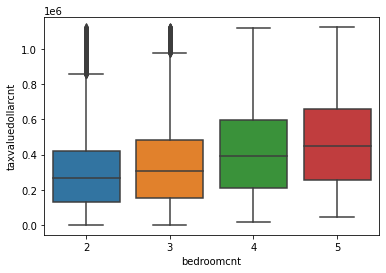

In [14]:
sns.boxplot(x = 'bedroomcnt',y='taxvaluedollarcnt',data = train)

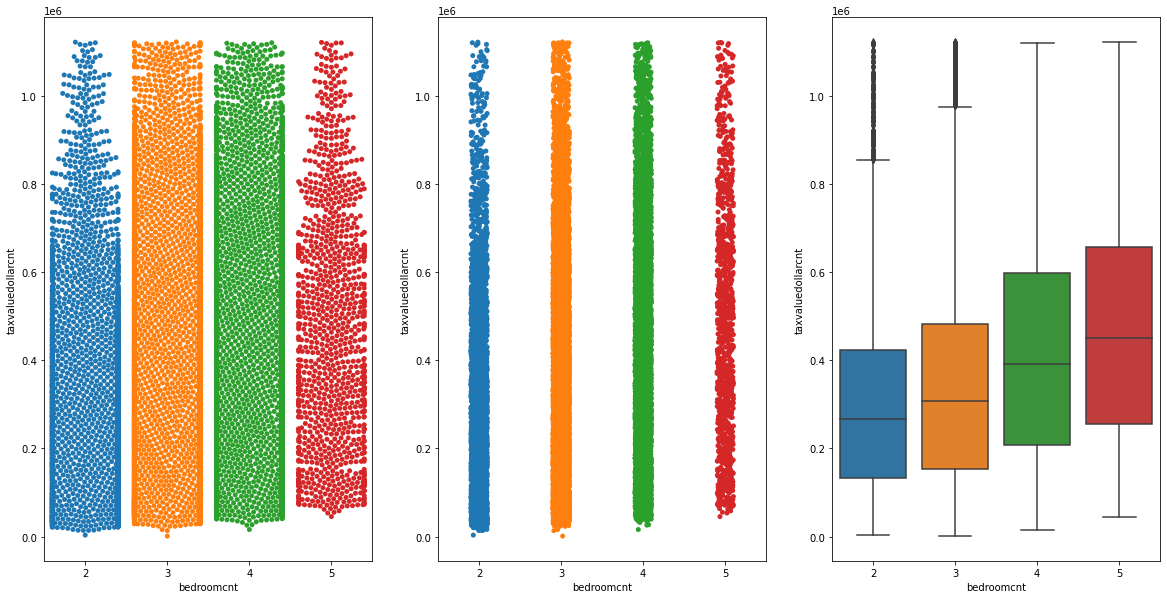

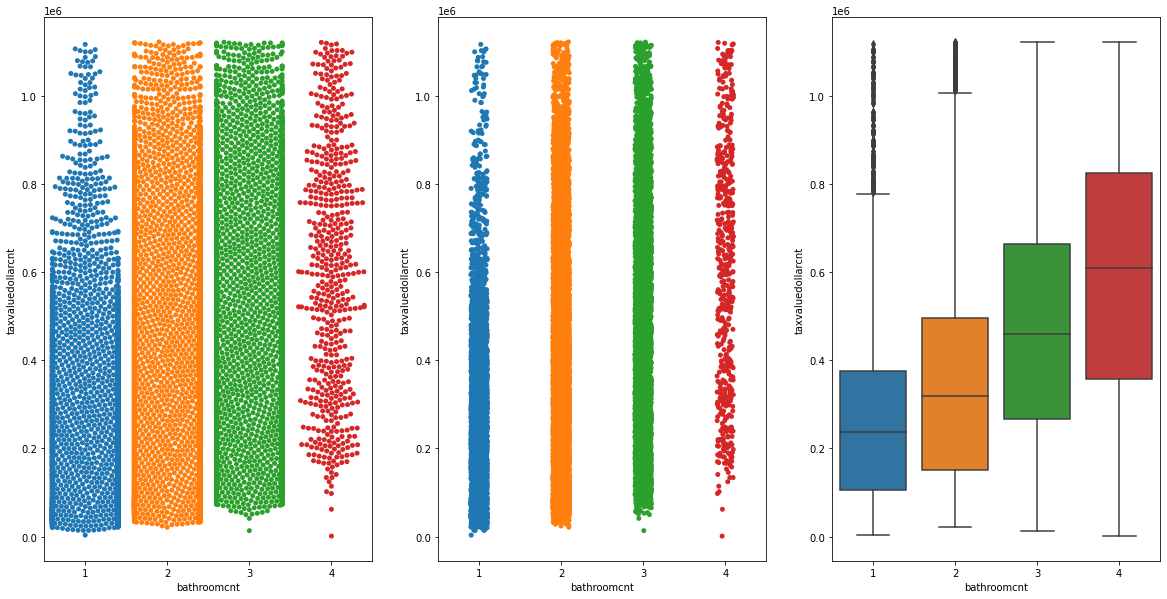

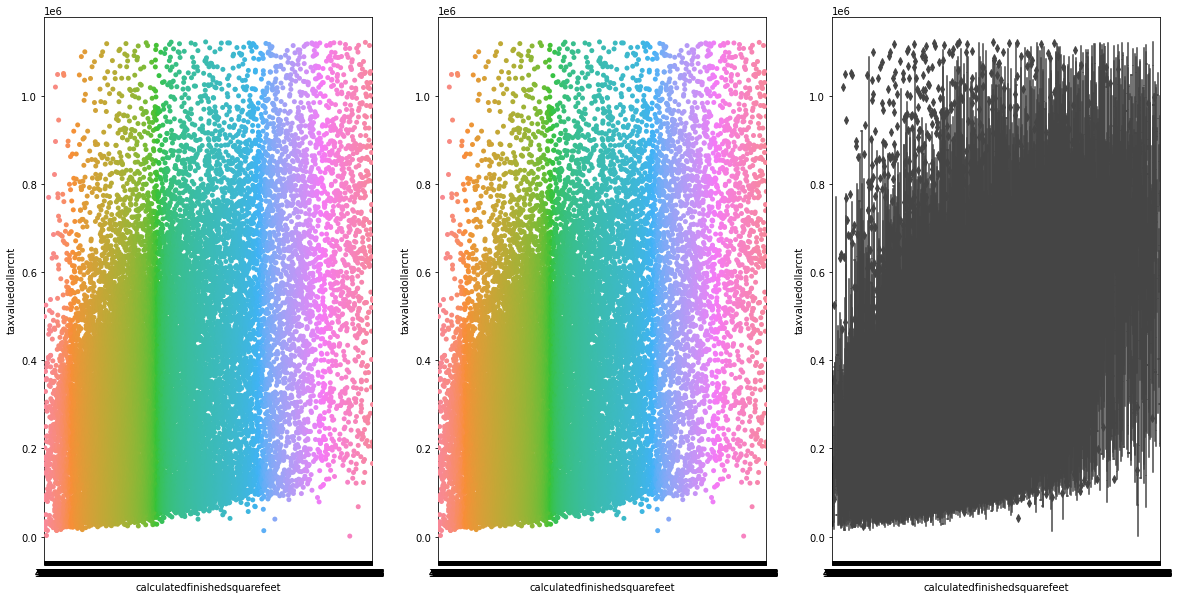

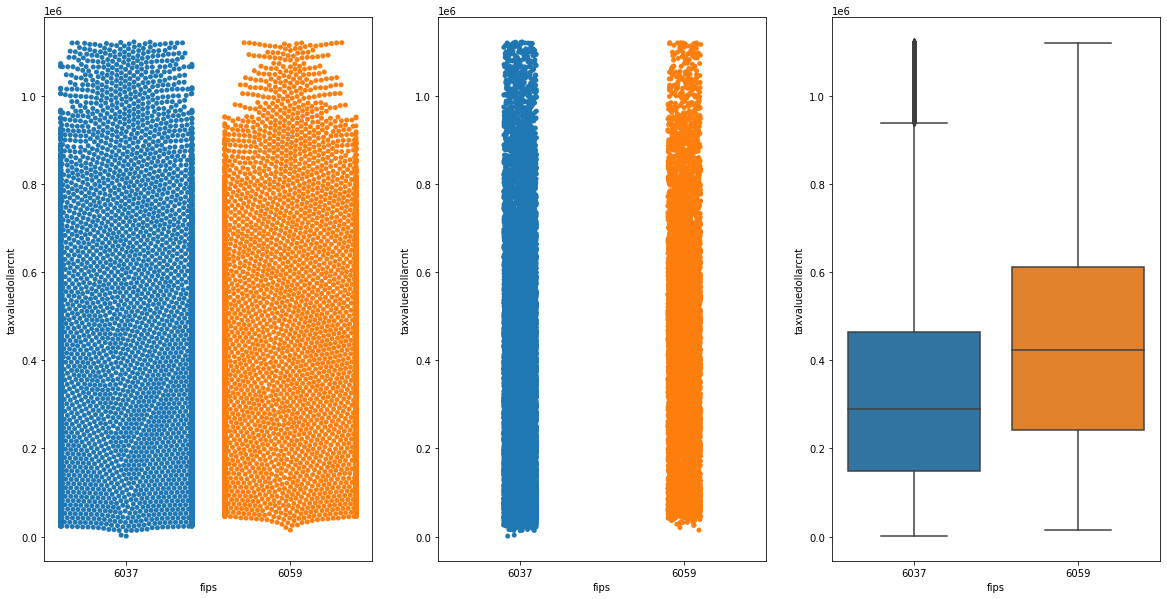

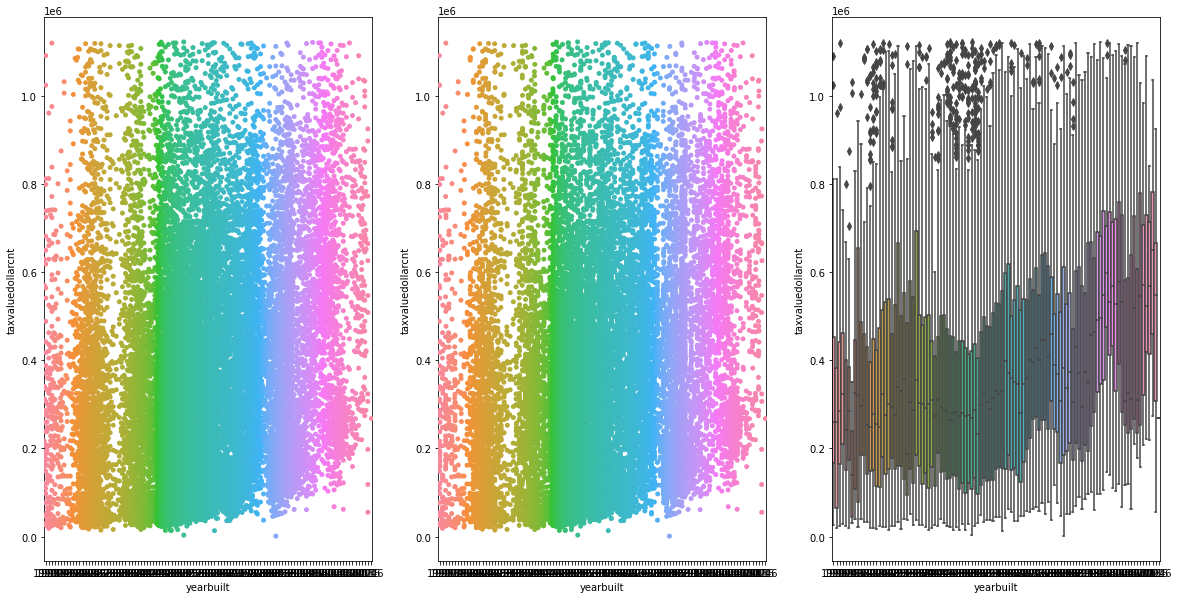

In [15]:
categories = ['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','fips','yearbuilt']
continuous = ['taxvaluedollarcnt']
explore.plot_categorical_and_continuous_vars(train,continuous,categories)

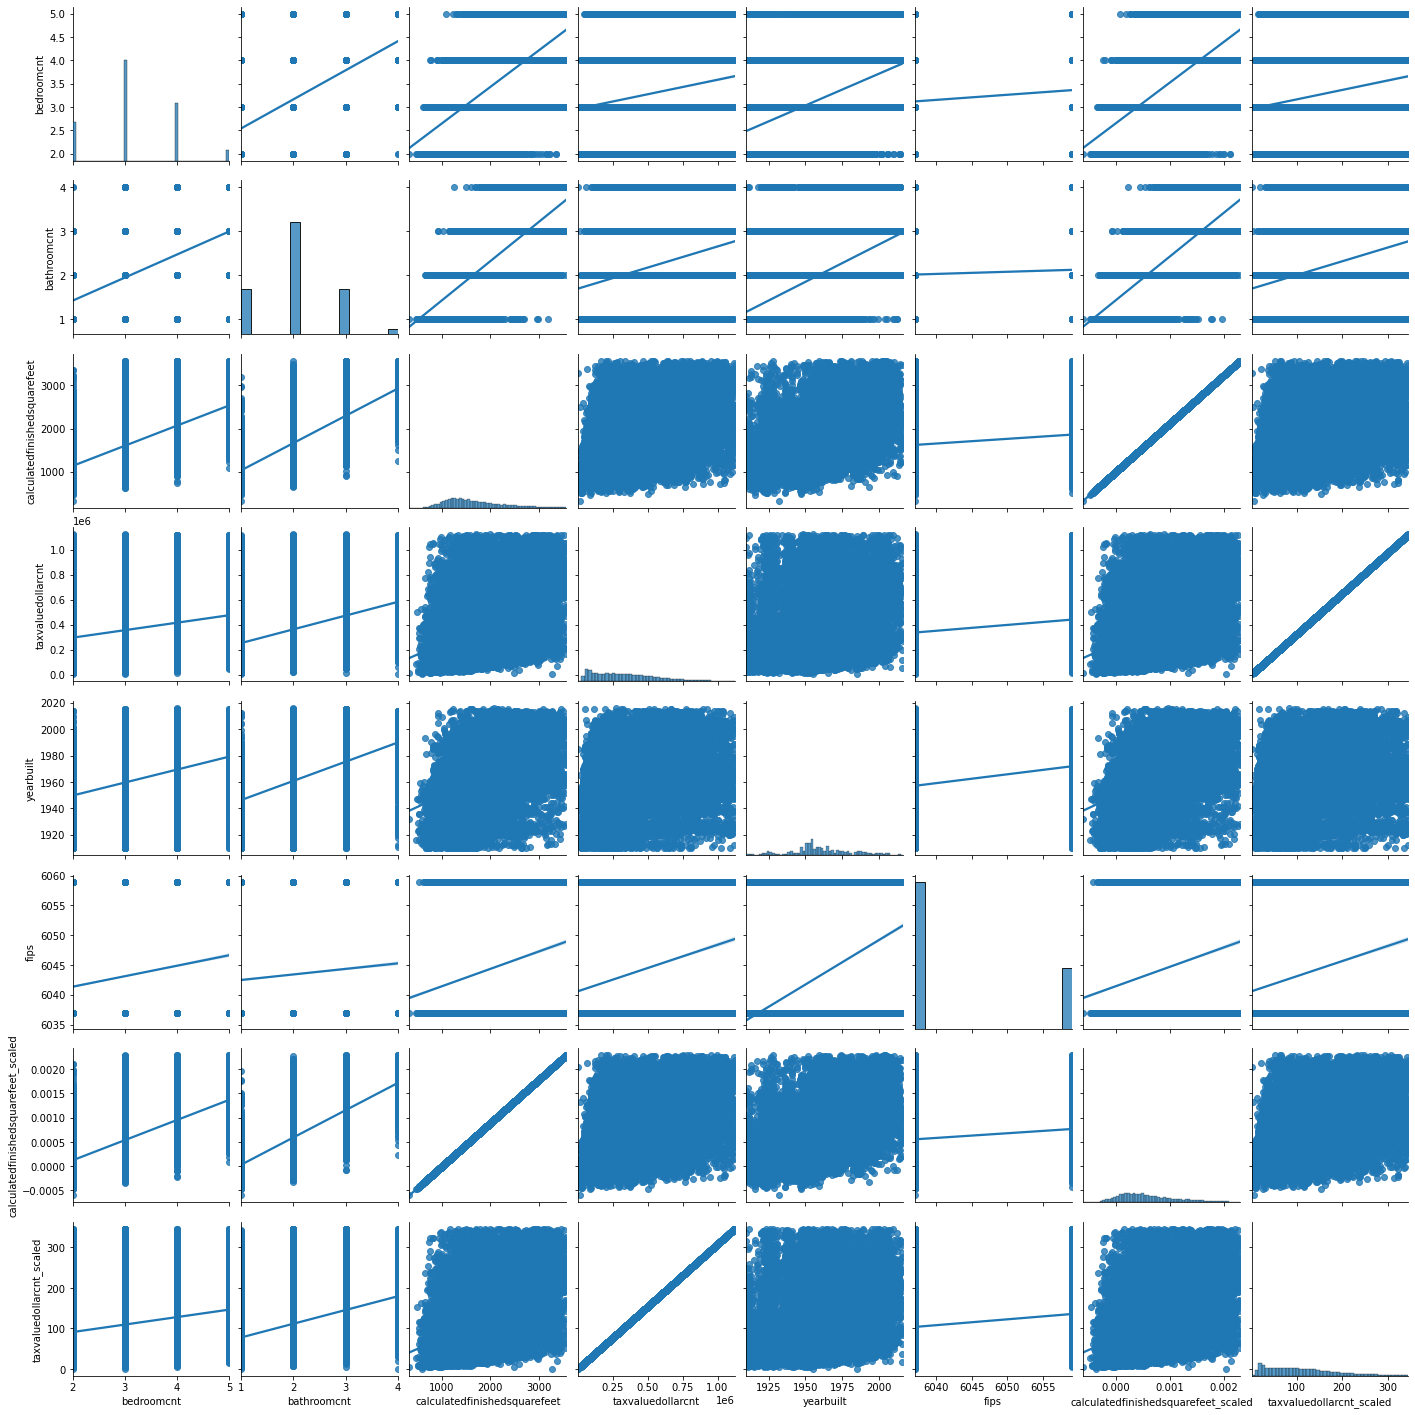

In [16]:
explore.plot_variable_pairs(train)